In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from torchsummary import summary
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# 데이터 로드
url = "https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv"
df = pd.read_csv(url)
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [3]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [4]:
# 데이터 로드 (이전 전처리된 데이터 사용)
# LabelEncoder 객체 생성
encoder = LabelEncoder()
# 'Sex' 컬럼을 숫자로 변환 (male=1, female=0 자동 할당됨)
#  map()으로도 가능. -> 직접 숫자 할당 가능.
df['sex'] = encoder.fit_transform(df['sex'])
df['smoker'] = encoder.fit_transform(df['smoker'])
df['region'] = encoder.fit_transform(df['region'])

df

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520
...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,1,10600.54830
1334,18,0,31.920,0,0,0,2205.98080
1335,18,0,36.850,0,0,2,1629.83350
1336,21,0,25.800,0,0,3,2007.94500


In [5]:
# 데이터와 타겟 분리
X = df.drop('charges', axis=1).values
y = df['charges'].values
print(X)
print(y)

[[19.    0.   27.9   0.    1.    3.  ]
 [18.    1.   33.77  1.    0.    2.  ]
 [28.    1.   33.    3.    0.    2.  ]
 ...
 [18.    0.   36.85  0.    0.    2.  ]
 [21.    0.   25.8   0.    0.    3.  ]
 [61.    0.   29.07  0.    1.    1.  ]]
[16884.924   1725.5523  4449.462  ...  1629.8335  2007.945  29141.3603]


In [6]:
# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

target_scaler = StandardScaler()
y = target_scaler.fit_transform(y.reshape(-1, 1))

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [7]:
# 4. 텐서로 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [8]:
# 5. DataLoader 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [9]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1070, 6), (268, 6), (1070, 1), (268, 1))

In [10]:
# 6. 회귀 모델 정의
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(6, 128),
            nn.ReLU(),
            #nn.BatchNorm1d(128),
            #nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            #nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

In [11]:
# 7. 디바이스 설정, 모델/손실/옵티마이저 정의
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RegressionModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
# 8. 학습 루프
model.train()
num_epochs = 30
for epoch in range(num_epochs):
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # 🔹 테스트 MSE 계산 추가
    model.eval()
    with torch.no_grad():
        total_mse = 0
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            predictions = model(X_test)
            mse = criterion(predictions, y_test)
            total_mse += mse.item()
        avg_mse = total_mse / len(test_loader)
    model.train()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}, Test MSE: {avg_mse:.4f}")

Epoch 1/30, Loss: 0.6349, Test MSE: 0.2820
Epoch 2/30, Loss: 0.2423, Test MSE: 0.1899
Epoch 3/30, Loss: 0.1843, Test MSE: 0.1370
Epoch 4/30, Loss: 0.1631, Test MSE: 0.1353
Epoch 5/30, Loss: 0.1593, Test MSE: 0.1335
Epoch 6/30, Loss: 0.1549, Test MSE: 0.1260
Epoch 7/30, Loss: 0.1528, Test MSE: 0.1245
Epoch 8/30, Loss: 0.1504, Test MSE: 0.1260
Epoch 9/30, Loss: 0.1533, Test MSE: 0.1239
Epoch 10/30, Loss: 0.1464, Test MSE: 0.1248
Epoch 11/30, Loss: 0.1470, Test MSE: 0.1245
Epoch 12/30, Loss: 0.1521, Test MSE: 0.1255
Epoch 13/30, Loss: 0.1472, Test MSE: 0.1245
Epoch 14/30, Loss: 0.1453, Test MSE: 0.1299
Epoch 15/30, Loss: 0.1428, Test MSE: 0.1193
Epoch 16/30, Loss: 0.1395, Test MSE: 0.1203
Epoch 17/30, Loss: 0.1439, Test MSE: 0.1212
Epoch 18/30, Loss: 0.1349, Test MSE: 0.1207
Epoch 19/30, Loss: 0.1357, Test MSE: 0.1233
Epoch 20/30, Loss: 0.1361, Test MSE: 0.1208
Epoch 21/30, Loss: 0.1330, Test MSE: 0.1268
Epoch 22/30, Loss: 0.1353, Test MSE: 0.1168
Epoch 23/30, Loss: 0.1346, Test MSE: 0.12

In [13]:
# 평가
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

model.eval()
preds, actuals = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch).cpu().numpy()
        preds.extend(outputs)
        actuals.extend(y_batch.numpy())

mse = mean_squared_error(actuals, preds)
print(f"Test MSE: {mse:.4f}")

Test MSE: 0.1277


In [14]:
# numpy 변환
preds = np.array(preds)
actuals = np.array(actuals)

# 역변환
preds_original = target_scaler.inverse_transform(preds)
actuals_original = target_scaler.inverse_transform(actuals)

In [15]:
# 성능 지표 계산
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
mse = mean_squared_error(actuals_original, preds_original)
rmse = np.sqrt(mse)
r2 = r2_score(actuals_original, preds_original)

print(f"\n[평가 결과]")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# 예시: 예측값 5개 출력
print("\n[예측 vs 실제 (일부)]")
for i in range(5):
    print(f"예측: {preds_original[i][0]:.2f}, 실제: {actuals_original[i][0]:.2f}")


[평가 결과]
Mean Squared Error (MSE): 18709208.0000
Root Mean Squared Error (RMSE): 4325.4142
R² Score: 0.8824

[예측 vs 실제 (일부)]
예측: 12331.90, 실제: 9724.53
예측: 9741.92, 실제: 8547.69
예측: 47044.08, 실제: 45702.02
예측: 13912.51, 실제: 12950.07
예측: 10637.59, 실제: 9644.25


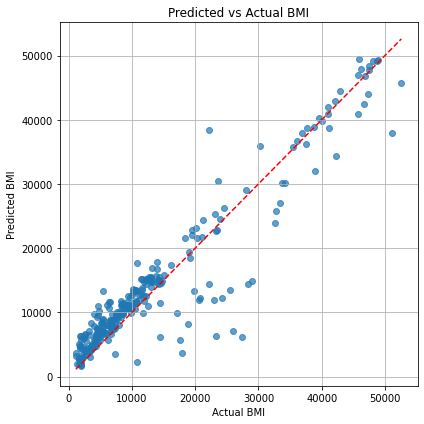

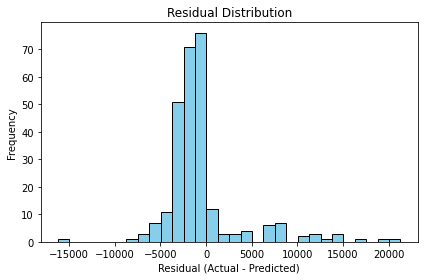

In [16]:
import matplotlib.pyplot as plt

# 1. 예측값 vs 실제값
plt.figure(figsize=(6, 6))
plt.scatter(actuals_original, preds_original, alpha=0.7)
plt.plot([actuals_original.min(), actuals_original.max()],
         [actuals_original.min(), actuals_original.max()], 'r--')
plt.xlabel("Actual BMI")
plt.ylabel("Predicted BMI")
plt.title("Predicted vs Actual BMI")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Residual Histogram (예측 오차 분포)
residuals = actuals_original - preds_original
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.tight_layout()
plt.show()